In [1]:
from matplotlib.pyplot import MultipleLocator
import  torch.nn as nn
import torch
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from torch.autograd import Variable
import os
import pandas as pd
from torchvision import transforms
import numpy as np
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
from torchsummary import summary
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif']=['SimHei'] # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False # 用来正常显示负号
#显示所有列
pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', None)

In [2]:
%%time
'''
path = r'/home/gongzicheng/strategy/Stock/上线策略/df_model_2021/'
file_list = os.listdir(path)
date_list = [i.split('.')[0].split('_')[1] for i in file_list ]
date_list.sort()
now_date = date_list[-1]
print(now_date)

df_feature = pd.read_csv(path+'df_{}.csv'.format(now_date))
'''
df_feature = pd.read_csv('D:/quantum_learning/backtest_by_gong/data_for_model_multi_pct_standard.csv')
df_feature.index = df_feature['TRADE_DATE'].apply(str)
df_feature.index = [datetime.datetime.strptime(x,'%Y%m%d') for x in df_feature.index]
df_feature['month'] = df_feature['TRADE_DATE'].apply(lambda s:int(str(s)[4:6]))
print(df_feature.shape)
df_feature.head()

(1160753, 517)
Wall time: 3min 7s


,TRADE_DATE,SECURITY_ID,PRE_CLOSE_PRICE_1,CLOSE_PRICE_1,OPEN_PRICE_1,HIGHEST_PRICE_1,LOWEST_PRICE_1,ACCUM_ADJ_FACTOR,VWAP,TICKER_SYMBOL_x,EXCHANGE_CD,SEC_SHORT_NAME,SEC_FULL_NAME,PARTY_ID,INDUSTRY,INDUSTRY_SYMBOL,INTO_DATE,OUT_DATE,IS_NEW,INDUSTRY_ID_1ST,INDUSTRY_NAME_1ST,INDUSTRY_ID_2ND,INDUSTRY_NAME_2ND,INDUSTRY_ID_3RD,INDUSTRY_NAME_3RD,ID_x,SECURITY_ID_INT_x,code_x,TICKER_SYMBOL_y,TotalFixedAssets,IntFreeCL,IntFreeNCL,IntCL,IntDebt,NetDebt,NetTangibleAssets,WorkingCapital,NetWorkingCapital,TotalPaidinCapital,RetainedEarnings,OperateNetIncome,ValueChgProfit,NetIntExpense,EBIT,EBITDA,EBIAT,NRProfitLoss,NIAPCut,FCFF,FCFE,DA,TRevenueTTM,TCostTTM,RevenueTTM,CostTTM,GrossProfitTTM,SalesExpenseTTM,AdminExpenseTTM,FinanExpenseTTM,AssetImpairLossTTM,NPFromOperatingTTM,NPFromValueChgTTM,OperateProfitTTM,NonOperatingNPTTM,TProfitTTM,NetProfitTTM,NetProfitAPTTM,SaleServiceRenderCashTTM,NetOperateCFTTM,NetInvestCFTTM,NetFinanceCFTTM,GrossProfit,ID_y,SECURITY_ID_INT_y,code_y,TICKER_SYMBOL_x.1,EPS,DilutedEPS,CashDividendCover,DividendCover,DividendPaidRatio,RetainedEarningRatio,CashEquivalentPS,DividendPS,EPSTTM,NetAssetPS,TORPS,TORPSLatest,OperatingRevenuePS,OperatingRevenuePSLatest,OperatingProfitPS,OperatingProfitPSLatest,CapitalSurplusFundPS,SurplusReserveFundPS,UndividedProfitPS,RetainedEarningsPS,OperCashFlowPS,CashFlowPS,EnterpriseFCFPS,ShareholderFCFPS,ID_x.1,SECURITY_ID_INT_x.1,code_x.1,TICKER_SYMBOL_y.1,Variance20,Variance60,Variance120,Kurtosis20,Kurtosis60,Kurtosis120,Alpha20,Alpha60,Alpha120,Beta20,Beta60,Beta120,SharpeRatio20,SharpeRatio60,SharpeRatio120,TreynorRatio20,TreynorRatio60,TreynorRatio120,InformationRatio20,InformationRatio60,InformationRatio120,GainVariance20,GainVariance60,GainVariance120,LossVariance20,LossVariance60,LossVariance120,GainLossVarianceRatio20,GainLossVarianceRatio60,GainLossVarianceRatio120,RealizedVolatility,Beta252,DASTD,CmraCNE5,HsigmaCNE5,ID_y.1,SECURITY_ID_INT_y.1,code_y.1,TICKER_SYMBOL_x.2,ACD6,ACD20,EMA10,EMA12,EMA120,EMA20,EMA26,EMA5,EMA60,MA120,MA20,MA10,MA5,MA60,APBMA,BBI,BBIC,TEMA10,TEMA5,MA10Close,ID_x.2,SECURITY_ID_INT_x.2,code_x.2,TICKER_SYMBOL_y.2,CurrentRatio,QuickRatio,DebtEquityRatio,LongDebtToWorkingCapital,EquityFixedAssetRatio,LongDebtToAsset,BondsPayableToAsset,LongTermDebtToAsset,EquityToAsset,CurrentAssetsRatio,NonCurrentAssetsRatio,FixAssetRatio,IntangibleAssetRatio,BLEV,DebtsAssetRatio,MLEV,InterestCover,SuperQuickRatio,TSEPToInterestBearDebt,DebtTangibleEquityRatio,TangibleAToInteBearDebt,TangibleAToNetDebt,NOCFToTLiability,NOCFToInterestBearDebt,NOCFToNetDebt,TSEPToTotalCapital,InteBearDebtToTotalCapital,REC,DAREC,GREC,FY12P,DAREV,GREV,SFY12P,DASREV,GSREV,FEARNG,FSALESG,EPIBS,EgibsLong,ID_y.2,SECURITY_ID_INT_y.2,code_y.2,TICKER_SYMBOL_x.3,InventoryTRate,InventoryTDays,ARTRate,ARTDays,AccountsPayablesTRate,AccountsPayablesTDays,CurrentAssetsTRate,FixedAssetsTRate,EquityTRate,TotalAssetsTRate,CashConversionCycle,OperatingCycle,ID_x.3,SECURITY_ID_INT_x.3,code_x.3,TICKER_SYMBOL_y.3,AD,AD20,AD6,CoppockCurve,ASI,ChaikinOscillator,ChaikinVolatility,EMV14,EMV6,plusDI,minusDI,ADX,ADXR,Aroon,AroonDown,AroonUp,DEA,DIFF,DDI,DIZ,DIF,MACD,MTM,MTMMA,PVT,PVT6,PVT12,TRIX5,TRIX10,UOS,MA10RegressCoeff12,MA10RegressCoeff6,PLRC6,PLRC12,SwingIndex,Ulcer10,Ulcer5,DHILO,Hurst,ID_y.3,SECURITY_ID_INT_y.3,code_y.3,TICKER_SYMBOL_x.4,ADTM,ATR14,ATR6,BIAS10,BIAS20,BIAS5,BIAS60,BollDown,BollUp,CCI10,CCI20,CCI5,CCI88,KDJ_K,KDJ_D,KDJ_J,ROC6,ROC20,SBM,STM,UpRVI,DownRVI,RVI,SRMI,RSI,ChandeSD,ChandeSU,CMO,DBCD,ARC,HBETA,HSIGMA,DDNSR,DDNCR,BackwardADJ,REVS5,REVS10,REVS20,DVRAT,DDNBT,Skewness,FiftyTwoWeekHigh,CMRA,ILLIQUIDITY,Volatility,MFI,WVAD,MAWVAD,REVS60,REVS120,REVS250,REVS750,REVS5m20,REVS5m60,REVS5Indu1,REVS20Indu1,Volumn1M,Volumn3M,Price1M,Price3M,Price1Y,Rank1M,ID_x.4,SECURITY_ID_INT_x.4,code_x.4,TICKER_SYMBOL_y.4,FinancingCashGrowRate,OperCashGrowRate,InvestCashGrowRate,SaleServiceCashToOR,CashRateOfSales,NOCFToOperatingNI,OperCashInToCurrentLiability,CashToCurrentLiability,CTOP,CTP5,CFO2EV,ACCA,

In [8]:
#f_all = [i for i in df_feature.columns.tolist() if i.split('_')[0]=='f']
alpha_p1 = ['ACD20', 'BBIC', 'MA10Close', 'BBIC', 'BIAS10',
       'BIAS20', 'BIAS60', 'ROC20', 'REVS5', 'REVS10', 'REVS20',
       'REVS5Indu1', 'REVS20Indu1', 'Price1M', 'Price3M', 'RC24',
       'Alpha20', 'RealizedVolatility', 'plusDI', 'PLRC6', 'VOL10',
       'VOL5'] # 
alpha_p2 =  ['ACD6', 'BIAS5', 'ROC6', 'SRMI', 'Volatility', 'Volumn1M',
       'Rank1M', 'BearPower', 'BullPower', 'RC12', 'CoppockCurve',
       'ASI', 'MACD', 'MTM', 'TRIX5', 'TRIX10', 'PLRC12',
       'SwingIndex', 'TVSTD6', 'VOL20', 'STOM', 'PEHist20']
alpha_p3 = [
        'CCI10', 'CCI20', 'CCI5', 'CMO', 'DBCD', 'ILLIQUIDITY',
       'REVS60', 'Volumn3M', 'AR', 'CR20', 'Elder', 'Variance20',
       'SharpeRatio20', 'InformationRatio20', 'GainVariance20',
       'GainVariance60', 'ChaikinVolatility', 'EMV14', 'minusDI',
       'DIFF', 'MTMMA', 'UOS', 'MA10RegressCoeff12',
       'MA10RegressCoeff6', 'TVMA6', 'TVSTD20', 'VEMA10', 'VEMA12',
       'VEMA5', 'VOL60', 'VROC12', 'VROC6', 'VSTD10', 'VSTD20',
       'DAVOL5', 'DAVOL10', 'STOQ', 'LCAP'] 
alpha_p4 = [
        'ADTM', 'KDJ_K', 'KDJ_J', 'RSI', 'Skewness', 'MFI',
       'WVAD', 'REVS5m20', 'Price1Y', 'JDQS20', 'Alpha60',
       'SharpeRatio60', 'InformationRatio60', 'GainLossVarianceRatio20',
       'DASTD', 'HsigmaCNE5', 'AroonUp', 'DDI', 'DIZ', 'DIF',
       'VDIFF', 'VEMA26', 'VOL120', 'VR', 'DAVOL20', 'STOA',
       'PEHist60']
alpha_p5 = [
        'FY12P',
       'EPIBS', 'InvestCashGrowRate', 'OperCashGrowRate', 'CCI88',
       'KDJ_D', 'RVI', 'HSIGMA', 'DDNSR', 'DDNCR', 'MAWVAD',
       'REVS120', 'REVS5m60', 'BR', 'ARBR', 'MassIndex', 'TOBT',
       'PSY', 'RSTR504', 'TaxRatio', 'ROECut', 'EPS',
       'OperatingProfitPSLatest', 'Variance60', 'Variance120',
       'Beta20', 'TreynorRatio20', 'TreynorRatio60', 'GainVariance120',
       'LossVariance60', 'LossVariance120', 'GainLossVarianceRatio60',
       'ChaikinOscillator', 'EMV6', 'Aroon', 'DEA', 'TVMA20',
       'VDEA', 'VMACD', 'VOL240', 'VOSC', 'MoneyFlow20', 'PEIndu',
       'PEHist120', 'NLSIZE']
alpha_p6 = [ 'CTOP',
       'CTP5', 'ACCA', 'OperCashInToAsset', 'OperatingProfitGrowRate',
       'RetainedEarnings', 'NRProfitLoss', 'NIAPCut', 'TRevenueTTM',
       'TCostTTM', 'RevenueTTM', 'CostTTM', 'NonOperatingNPTTM',
       'TProfitTTM', 'NetProfitTTM', 'NetProfitAPTTM',
       'NetInvestCFTTM', 'BollDown', 'SBM', 'STM', 'DownRVI',
       'ChandeSD', 'ChandeSU', 'REVS750', 'PVI', 'RSTR24',
       'RSTR12', 'ETOP', 'ROIC', 'OperatingNIToTP', 'DilutedEPS',
       'CashEquivalentPS', 'DividendPS', 'EPSTTM', 'NetAssetPS',
       'TORPS', 'TORPSLatest', 'OperatingRevenuePS',
       'OperatingRevenuePSLatest', 'OperatingProfitPS',
       'SurplusReserveFundPS', 'UndividedProfitPS', 'RetainedEarningsPS',
       'OperCashFlowPS', 'Alpha120', 'Beta60', 'SharpeRatio120',
       'TreynorRatio120', 'InformationRatio120', 'LossVariance20',
       'GainLossVarianceRatio120', 'Beta252', 'AroonDown', 'Ulcer10',
       'Ulcer5', 'DHILO', 'PE', 'PCF', 'ASSI', 'LFLO', 'TA2EV',
       'PBIndu', 'PSIndu', 'PCFIndu', 'PEHist250', 'ForwardPE',
       'MktValue', 'NegMktValue', 'TEAP', 'NIAP', 'CETOP']
alpha_p7 = ['NetProfitCashCover', 'NPParentCompanyCutYOY', 'NetAssetGrowRate',
       'TotalProfitGrowRate', 'NetProfitGrowRate', 'EARNMOM', 'EMA120',
       'EMA20', 'EMA26', 'MA10', 'MA20', 'MA120',
       'NetTangibleAssets', 'OperateNetIncome', 'ValueChgProfit',
       'NPFromOperatingTTM', 'OperateProfitTTM',
       'SaleServiceRenderCashTTM', 'NetOperateCFTTM', 'NetFinanceCFTTM',
       'ATR6', 'BollUp', 'UpRVI', 'FiftyTwoWeekHigh', 'REVS250',
       'NetProfitRatio', 'OperatingProfitRatio', 'NPToTOR',
       'OperatingProfitToTOR', 'GrossIncomeRatio', 'SalesCostRatio',
       'ROA5', 'ROE', 'ROE5', 'ROEDiluted', 'ROEWeighted',
       'InvestRAssociatesToTPLatest', 'DividendPaidRatio',
       'RetainedEarningRatio', 'CapitalSurplusFundPS', 'Beta120',
       'StaticPE', 'TotalAssets']

建模

In [9]:
class Mydataset():
 
    def __init__(self,xx,yy,transform=None):
        self.x=xx
        self.y=yy
        self.tranform = transform
 
    def __getitem__(self,index):
        x1=self.x[index]
        y1=self.y[index]
        if self.tranform !=None:
            return self.tranform(x1),y1
        return x1,y1
 
    def __len__(self):
        return len(self.x)

In [10]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from keras import initializers

'''样本数据生成函数'''
def generate_data(data_in,sequence_in,colx,coly,step_in=1):
    X = []#初始化输入序列X
    Y= []#初始化输出序列Y
    #
    for i in range(0,len(data_in)-sequence_in,step_in):
        X.append(np.array(data_in.iloc[i:(i+sequence_in),][colx].values,dtype=np.float32)) # .T
        Y.append(np.array(data_in.iloc[(i+sequence_in),][coly],dtype=np.float32)) #创建数据集长度5，将标识colx设置为所有的因子，coly设置为label2
#     return X,Y
    return  np.array(X, dtype=np.float32), np.array(Y, dtype=np.float32)

In [11]:
%%time
pnl_cols = ['TRADE_DATE','SECURITY_ID','TICKER_SYMBOL','close_ret','label','prob_po','rank','SEC_SHORT_NAME','INDUSTRY_ID_1ST','INDUSTRY_NAME_1ST','INDUSTRY_ID_2ND','INDUSTRY_NAME_2ND','INDUSTRY_ID_3RD','INDUSTRY_NAME_3RD']
factors = alpha_p1+alpha_p2+alpha_p3+alpha_p4+alpha_p5
df_model = df_feature[~np.isnan(df_feature['close_ret'])].copy(deep=True) # 这里面有值的就是true，为close_ret=0就是false
df_model = df_model[df_model['TRADE_DATE']>20180601]
df_model = df_model[df_model['TRADE_DATE']<20200601]
df_model.index=df_model['TRADE_DATE']
 
colx = factors
coly = 'close_ret'
############# param ####################
batch=1000
round_num=2 # 训练轮数
train_num = 10 # 训练集大小
sequence = 5 # LSTM的长度 
learning_rate = 0.0001
hidden_s = 100#len(factors) #20

tf.random.set_seed(2021)

############# param end ################
df_pnl = pd.DataFrame()
weekiter_list = df_model['weekiter'].unique().tolist()
for w in range(train_num+sequence,len(weekiter_list)):
    data_train = df_model[df_model['weekiter'].isin(weekiter_list[w-train_num-sequence:w])].copy(deep=True) # w这一周的不能用，因为训练数据要用到未来一周的收益
    data_test = df_model[df_model['weekiter'].isin(weekiter_list[w-sequence+1:w+1])].copy(deep=True)
    
    long_y = np.percentile(data_train[coly], 70)
    short_y = np.percentile(data_train[coly], 30) # y的训练结果值在label列，也就是收益 
    
    data_train['label'] = data_train[coly].apply(lambda s: 1 if s>long_y else (0 if s<short_y else 2)) # 决定是否使用这个样本，1：70%以上，0：30%以下，2：30%-70%之间
    data_train = data_train[data_train['label'].isin([1,0])].reset_index(drop=True) # isin筛选index为0和1的行，删除label为2的行
    data_test['label'] = data_test[coly].apply(lambda s:1 if s>0 else 0) # 测试的话就使用全部收益大于0的样本label为1，收益小于0的样本label全为0
    
    print('train start:{} # end:{}'.format(data_train.iloc[0]['TRADE_DATE'],data_train.iloc[-1]['TRADE_DATE'])) # 数据训练集的最后一个时间片作为结束日
    print('test start:{} # end:{}'.format(data_test.iloc[0]['TRADE_DATE'],data_test.iloc[-1]['TRADE_DATE']))
    
    print('train num:{}'.format(data_train.shape))
    print('test num:{}'.format(data_test.shape))
    print('加工序列数据')
    col_x = colx # 使用所有因子作为参数
    col_y = 'label' # 使用收益排在前30的股票标识作为训练的标签y
    X, Y = generate_data(data_train,sequence,col_x,col_y,1)
    X_act, Y_act = generate_data(data_test,sequence,col_x,col_y,1)
    print(len(Y_act))
    model = keras.Sequential()
    model.add(keras.layers.LSTM(hidden_s,input_shape= (sequence,len(col_x))))
    model.add(keras.layers.Dense(2, activation='softmax'))
    Y = keras.utils.to_categorical(Y, num_classes=2)
    
    adam = keras.optimizers.Adam(lr=learning_rate) # 0.000005
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X, Y, batch_size=batch, epochs=round_num,shuffle=True)
    # 模型验证
#     loss, accuracy = model.evaluate(testx,testy)
#     print('test accuracy: ', round(accuracy,5))
    
    # 预测
    result = model.predict(X_act, batch_size=batch ,verbose=0)
    preds_real_label_stat = [i[1] for i in result] # 获取概率
    preds_real_label = [np.argmax(i) for i in result] # 获取最大概率对应的标签，也就是哪只股票，在同一天收益最高
    
    dft_backtest = data_test.iloc[-len(preds_real_label_stat):].copy() # 获取所有股票收益的预测，每周
    dft_backtest['prob_po'] = preds_real_label_stat # 所有数据的收益预测，每一个训练集 15*4380只股票
    dft_backtest = dft_backtest.sort_values('prob_po',ascending=False) # 下降排序，也就是在同一天所有的股票按照收益全部下降排序，获取哪一只股票在这一周预测值最高
    dft_backtest['rank'] = [(i+1)/len(dft_backtest) for i in range(len(dft_backtest))] # 也就是所有股票每一个训练集整体的计数，有顺序的
    dft_backtest = dft_backtest[dft_backtest['weekiter']==weekiter_list[w]][pnl_cols] # 每一个训练集的pnl_cols导入到每一个训练集的标签 ，使用了pandas的标签查找功能
    
    df_pnl = df_pnl.append(dft_backtest) #为每一个训练集的df_pnl添加预测排序数据
    
    dft_backtest['pre_label'] = dft_backtest['prob_po'].apply(lambda s:1 if s>0.5 else 0) # 对于每一个训练集收益大于50%的股票标签放置为1，对于预测的数据集
    acc = dft_backtest[dft_backtest['pre_label']==dft_backtest['label']].shape[0]/dft_backtest.shape[0] # .shape[0]表示返回行数，这样就可以表示中签率，就是预测的这个要涨还是要跌和实际比较的匹配度
    print('pre acc:',round(acc,5))
#     break

train start:20180608 # end:20180914
test start:20180824 # end:20180921
train num:(28585, 518)
test num:(16151, 518)
加工序列数据
16146
Epoch 1/2
29/29 [==============================] - 5s 9ms/step - loss: 0.6931 - accuracy: 0.5244
Epoch 2/2
29/29 [==============================] - 0s 9ms/step - loss: 0.6798 - accuracy: 0.5688
pre acc: 0.53296
train start:20180615 # end:20180921
test start:20180831 # end:20180928
train num:(28676, 518)
test num:(16187, 518)
加工序列数据
16182
Epoch 1/2
29/29 [==============================] - 2s 16ms/step - loss: 0.6878 - accuracy: 0.5433
Epoch 2/2
29/29 [==============================] - 0s 9ms/step - loss: 0.6778 - accuracy: 0.5723
pre acc: 0.38499
train start:20180622 # end:20180928
test start:20180907 # end:20181012
train num:(28756, 518)
test num:(16217, 518)
加工序列数据
16212
Epoch 1/2
29/29 [==============================] - 2s 9ms/step - loss: 0.6913 - accuracy: 0.5346
Epoch 2/2
29/29 [==============================] - 0s 9ms/step - loss: 0.6770 - accuracy: 0.5

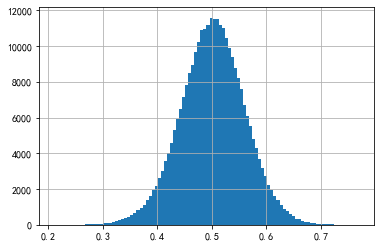

In [12]:
df_pnl['prob_po'].hist(bins=100);

<AxesSubplot:>

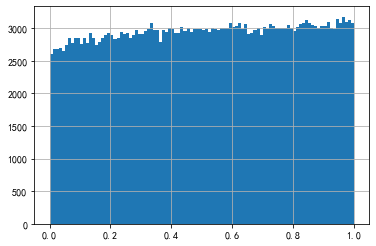

In [13]:
df_pnl['rank'].hist(bins=100)

Model: "sequential_85"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_85 (LSTM)              (None, 100)               102000    
                                                                 
 dense_85 (Dense)            (None, 2)                 202       
                                                                 
Total params: 102,202
Trainable params: 102,202
Non-trainable params: 0
_________________________________________________________________
None
batch:1000 # round_num:2 # train_num:10 # sequence:5 # 
learning_rate:0.0001 # hidden_s:100
夏普：0.404  #  胜率：0.5 # 盈亏比：1.077
最大回撤: 1.002 手续费：千2


<AxesSubplot:>

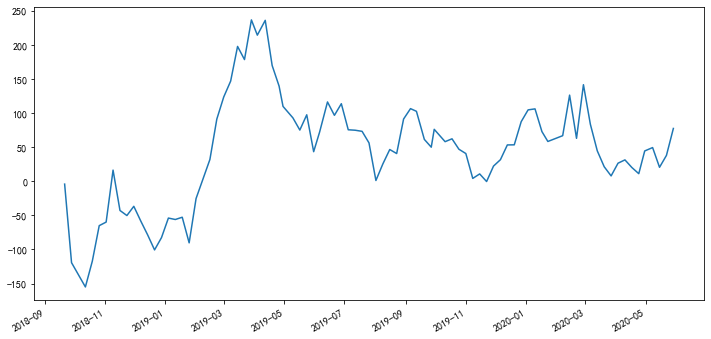

In [14]:
print(model.summary())
print('batch:{} # round_num:{} # train_num:{} # sequence:{} # '.format(batch,round_num,train_num,sequence))
print('learning_rate:{} # hidden_s:{}'.format(learning_rate,hidden_s))

#################
df_p = df_pnl[(df_pnl['rank']<0.1)].copy(deep=True).reset_index(drop=True)[['TRADE_DATE','TICKER_SYMBOL',coly]] # 提取预测值排序前10%的数据
df_p['TICKER_SYMBOL'] = df_p['TICKER_SYMBOL'].apply(lambda s:str(s) if len(str(s))==6 else '0'*(6-len(str(s)))+str(s)) #股票的标识还原到6位数
df_p['cnt'] = 1
df_pro = df_p.groupby('TRADE_DATE')['cnt',coly].sum().reset_index() # 求取股票的预测收益
# 平均买入50只股票，买入1000万
df_pro['ret'] = round(df_pro[coly]/df_pro['cnt'],5)*1000 # 相当于提取这前10%的预测数据，ret计算投入1000w*50的收益
df_pro['ret'] = df_pro['ret'] - 1000*0.002  # 相当于扣除手续费之后的收益
df_pro.index = df_pro['TRADE_DATE'].apply(str) # 获取交易日期的index
df_pro.index = [datetime.datetime.strptime(x,'%Y%m%d') for x in df_pro.index] # 获取标准格式的交易日期

df_sharp = df_pro['ret'] # 提取前10%的预测扣除手续费收益
df_sharp.columns=(['pro']) # 定义列名称
returns = [x / abs(10000000) for x in df_sharp.values] # 计算每只股票1000w带来的回报
sharp = np.average(returns) * 250 / (np.std(returns) * np.sqrt(250)) #计算夏普比（问题，为什么这个是250,因为定义是年回报，所以计算所有工作日）
sharp = round(sharp,3)
# 胜率 win_rate
win_rate = round(sum(df_sharp>0)/sum(df_sharp!=0),3) if sum(df_sharp!=0)!=0 else 0
# 盈亏比 wl_rate
win_pro  = int(sum(df_sharp[df_sharp>0])/sum(df_sharp>0)) if sum(df_sharp>0) else 0
loss_pro = abs(int(sum(df_sharp[df_sharp<0])/sum(df_sharp<0))) if sum(df_sharp<0) else 0
wl_rate = round(win_pro/loss_pro,3) if loss_pro!=0 else 0
print("夏普：{}  #  胜率：{} # 盈亏比：{}".format(sharp,win_rate,wl_rate))
x = np.array(returns).cumsum()
i = np.argmax(np.maximum.accumulate(x) - x)
j = np.argmax(x[:i])
max_dd = (x[j] - x[i])/x[j]
max_dd = round(max_dd,3)
print("最大回撤:",max_dd,'手续费：千2')
df_pro['ret'].cumsum().plot(figsize=(12,6))

10


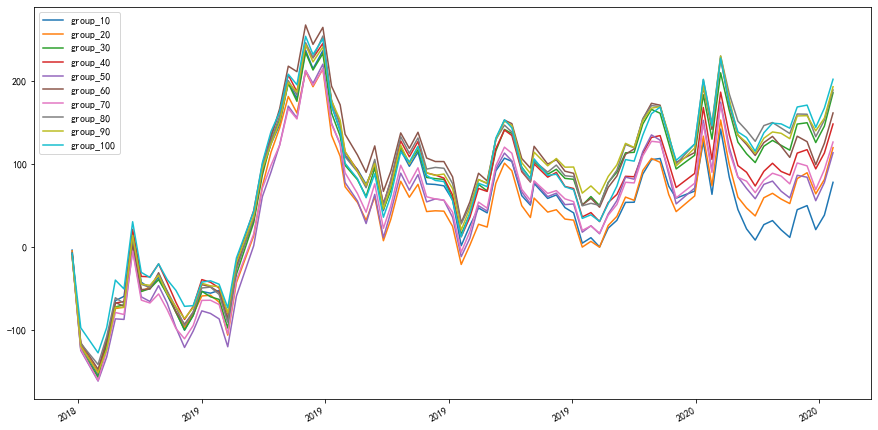

In [15]:
# 分层效果
print(train_num)
def get_group(s,r_list):
    g=0
    for i in range(len(r_list)-1):
        down = r_list[i]
        up = r_list[i+1]
        if s>=down and s<= up:
            g = int(up*100)
        else:
            continue
    return g

range_list = [i/100 for i in range(0,105,10)]
df_p = df_pnl[['TRADE_DATE','TICKER_SYMBOL',coly,'rank']].copy(deep=True)
df_p['group'] = df_pnl['rank'].apply(lambda s:get_group(s,range_list))
df_p = df_p.reset_index(drop=True)
df_p['cnt'] = 1
df_pro = df_p.groupby(['TRADE_DATE','group'])['cnt',coly].sum().reset_index()
df_pro['ret'] = round(df_pro[coly]/df_pro['cnt'],5)*1000
df_pro['ret_comm'] = df_pro['ret'] - 1000*0.002
df_pro.index = df_pro['TRADE_DATE'].apply(str)
df_pro.index = [datetime.datetime.strptime(x,'%Y%m%d') for x in df_pro.index]
df_pro.head()

plt.figure(figsize=(15,8))
x_major_locator=MultipleLocator(100)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
plt.xticks(rotation=300)
for group in df_pro.groupby('group')['ret_comm']:
    group[1].cumsum().plot(label = 'group_{}'.format(group[0]))
plt.legend()

No handles with labels found to put in legend.


10
平均收益： 0.001763198630467281 # 收益STD 0.06621831876908384
夏普：0.459  #  胜率：0.488 # 盈亏比：1.115
最大回撤: 0.979 手续费：千2


<AxesSubplot:>

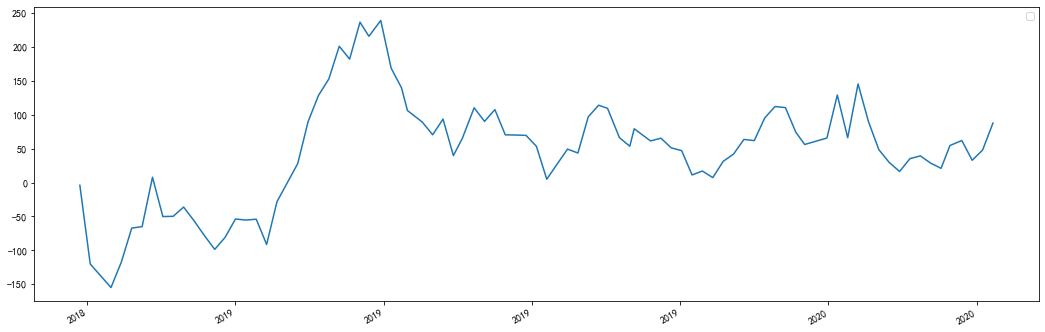

In [16]:
print(train_num)
df_p = df_pnl[df_pnl['rank']<0.15].copy(deep=True).reset_index(drop=True)[['TRADE_DATE','TICKER_SYMBOL',coly]]
df_p['TICKER_SYMBOL'] = df_p['TICKER_SYMBOL'].apply(lambda s:str(s) if len(str(s))==6 else '0'*(6-len(str(s)))+str(s))
df_p['cnt'] = 1
df_pro = df_p.groupby('TRADE_DATE')['cnt',coly].sum().reset_index()
# 平均买入50只股票，买入1000万
df_pro['ret'] = round(df_pro[coly]/df_pro['cnt'],5)*1000
df_pro['ret_comm'] = df_pro['ret'] - 1000*0.002
df_pro.index = df_pro['TRADE_DATE'].apply(str)
df_pro.index = [datetime.datetime.strptime(x,'%Y%m%d') for x in df_pro.index]
print('平均收益：',df_p[coly].mean(),'# 收益STD',df_p[coly].std())

df_sharp = df_pro['ret_comm']
df_sharp.columns=(['pro'])
returns = [x / abs(10000000) for x in df_sharp.values]
sharp = np.average(returns) * 250 / (np.std(returns) * np.sqrt(250))
sharp = round(sharp,3)
# 胜率 win_rate
win_rate = round(sum(df_sharp>0)/sum(df_sharp!=0),3) if sum(df_sharp!=0)!=0 else 0
# 盈亏比 wl_rate
win_pro  = int(sum(df_sharp[df_sharp>0])/sum(df_sharp>0)) if sum(df_sharp>0) else 0
loss_pro = abs(int(sum(df_sharp[df_sharp<0])/sum(df_sharp<0))) if sum(df_sharp<0) else 0
wl_rate = round(win_pro/loss_pro,3) if loss_pro!=0 else 0
print("夏普：{}  #  胜率：{} # 盈亏比：{}".format(sharp,win_rate,wl_rate))
x = np.array(returns).cumsum()
i = np.argmax(np.maximum.accumulate(x) - x)
j = np.argmax(x[:i])
max_dd = (x[j] - x[i])/x[j]
max_dd = round(max_dd,3)
print("最大回撤:",max_dd,'手续费：千2')

plt.figure(figsize=(15,8))
x_major_locator=MultipleLocator(100)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
plt.xticks(rotation=300)
plt.legend()
df_pro['ret_comm'].cumsum().plot(figsize=(18,6))

No handles with labels found to put in legend.


10
夏普：1.131  #  胜率：0.486 # 盈亏比：1.261
最大回撤: 0.732 手续费：千2


<AxesSubplot:>

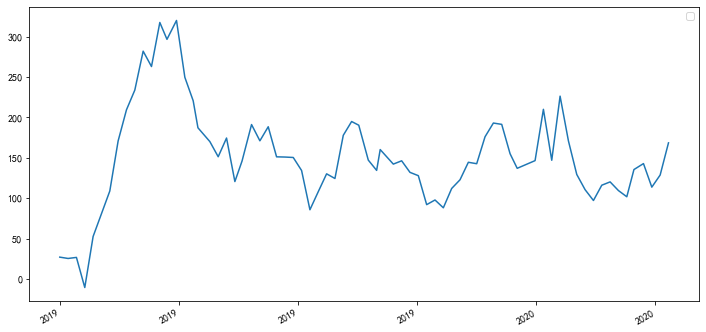

In [17]:
print(train_num)
df_present = df_pro[df_pro['TRADE_DATE']>20190101]
df_sharp = df_present['ret_comm']
df_sharp.columns=(['pro'])
returns = [x / abs(10000000) for x in df_sharp.values]
sharp = np.average(returns) * 250 / (np.std(returns) * np.sqrt(250))
sharp = round(sharp,3)
# 胜率 win_rate
win_rate = round(sum(df_sharp>0)/sum(df_sharp!=0),3) if sum(df_sharp!=0)!=0 else 0
# 盈亏比 wl_rate
win_pro  = int(sum(df_sharp[df_sharp>0])/sum(df_sharp>0)) if sum(df_sharp>0) else 0
loss_pro = abs(int(sum(df_sharp[df_sharp<0])/sum(df_sharp<0))) if sum(df_sharp<0) else 0
wl_rate = round(win_pro/loss_pro,3) if loss_pro!=0 else 0
print("夏普：{}  #  胜率：{} # 盈亏比：{}".format(sharp,win_rate,wl_rate))
x = np.array(returns).cumsum()
i = np.argmax(np.maximum.accumulate(x) - x)
j = np.argmax(x[:i])
max_dd = (x[j] - x[i])/x[j]
max_dd = round(max_dd,3)
print("最大回撤:",max_dd,'手续费：千2')
plt.figure(figsize=(15,8))
x_major_locator=MultipleLocator(100)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
plt.xticks(rotation=300)
plt.legend()
df_present['ret_comm'].cumsum().plot(figsize=(12,6))